In [1]:
import os
num_threads = "8"
os.environ["OMP_NUM_THREADS"] = num_threads
os.environ["OPENBLAS_NUM_THREADS"] = num_threads
os.environ["MKL_NUM_THREADS"] = num_threads
os.environ["VECLIB_MAXIMUM_THREADS"] = num_threads
os.environ["NUMEXPR_NUM_THREADS"] = num_threads

In [4]:
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad, Variable
import autograd
import autograd.numpy as np
import copy
import scipy as sp
from scipy import stats
from sklearn import metrics
import sys
import ot
import gwot
from gwot import models, sim, ts, util
import gwot.bridgesampling as bs
import dcor

import importlib
import models
import random
import model_poster as model_sim

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [5]:
importlib.reload(model_sim)

<module 'model_poster' from '/Users/Viresh/Desktop/Spring 2025/AI4TS/ATD-NSF/trajectory-inference/mfl/model_poster.py'>

In [6]:
device = torch.device("cpu") # torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)

In [7]:
PLT_CELL = 2.5

In [8]:
# set random seed
SRAND = 0
torch.manual_seed(SRAND)
np.random.seed(SRAND)

In [9]:
M = 100
N = 10
# setup simulation object
sim = gwot.sim.Simulation(V = model_sim.Psi, dV = model_sim.dPsi, birth_death = False, 
                          N = np.array([N, ]*(model_sim.T)),
                          T = model_sim.T, 
                          d = model_sim.dim, 
                          D = model_sim.D, 
                          t_final = model_sim.t_final, 
                          ic_func = model_sim.ic_func, 
                          pool = None)
# sample from simulation
sim.sample(steps_scale = int(model_sim.sim_steps/sim.T));

In [10]:
sim_gt = copy.deepcopy(sim)
sim_gt.N = np.array([500, ]*model_sim.T)
sim_gt.sample(steps_scale = int(model_sim.sim_steps/sim.T));

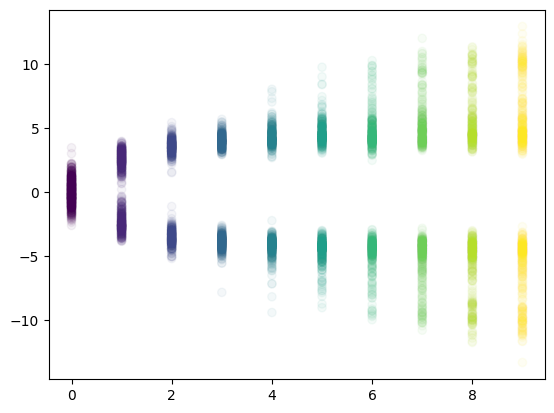

In [11]:
plt.scatter(sim_gt.t_idx, sim_gt.x[:, 0], alpha = 0.05, c = sim_gt.t_idx)

(-15.0, 15.0)

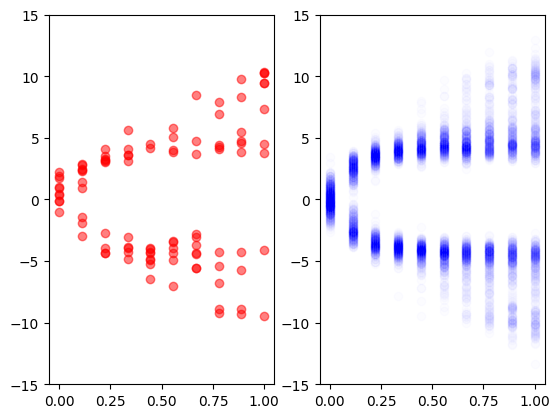

In [12]:
k = 0
plt.subplot(1, 2, 1)
plt.scatter(np.linspace(0, model_sim.t_final, model_sim.T)[sim.t_idx], sim.x[:, k], alpha = 0.5, color = "red")
plt.ylim(-15.0, 15.0)
plt.subplot(1, 2, 2)
plt.scatter(np.linspace(0, model_sim.t_final, model_sim.T)[sim_gt.t_idx], sim_gt.x[:, k], alpha = 0.01, color = "blue")
plt.ylim(-15.0, 15.0)

In [13]:
sim_gt_paths = copy.deepcopy(sim)
sim_gt_paths.T = 1_000
N_paths_gt = 64
paths_gt = sim_gt_paths.sample_trajectory(steps_scale = int(model_sim.sim_steps/sim_gt_paths.T), N = N_paths_gt)

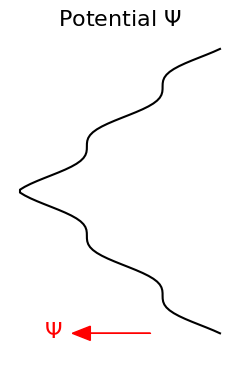

In [14]:
plt.figure(figsize = (PLT_CELL, 1.5*PLT_CELL))
xs = np.linspace(-15, 15, 100)
ys = [model_sim.Psi(x, 0) for x in xs]
plt.plot(ys, xs, color = "k")
plt.arrow(-100, -15, 50, 0, head_width = 1.5, head_length = 15, color = "red")
plt.annotate("Ψ", (-12.5, -15.5), color = "red", fontsize = 16)
plt.title("Potential $Ψ$", fontsize = 16)
plt.gca().invert_xaxis()
plt.yticks([])
plt.axis("off")
plt.tight_layout()
plt.savefig("potential_plot.pdf")

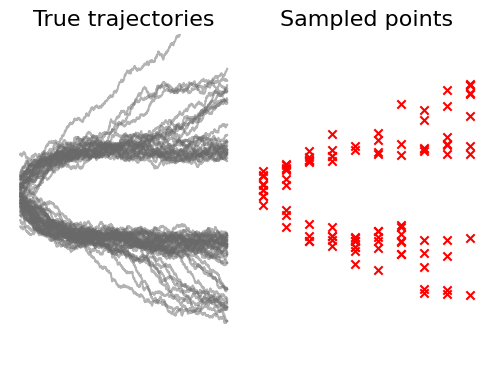

In [15]:
plt.figure(figsize = (2*PLT_CELL, 1.5*PLT_CELL))
plt.subplot(1, 2, 1)
plt.plot(np.linspace(0, 1, paths_gt.shape[1]), paths_gt[:, :, 0].T, color = "dimgrey", alpha = 0.5);
plt.title("True trajectories", fontsize = 16)
plt.ylim(-15, 15)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.scatter(np.linspace(0, model_sim.t_final, model_sim.T)[sim.t_idx], sim.x[:, k], color = "red", marker = "x")
plt.title("Sampled points", fontsize = 16)
plt.ylim(-15, 15)
plt.axis("off")
plt.tight_layout()
plt.savefig("trajectories_sample.pdf")

In [16]:
def gen_model(x0): 
    return models.TrajLoss(x0,
                        torch.tensor(sim.x, device = device), 
                        torch.tensor(sim.t_idx, device = device), 
                        dt = model_sim.t_final/model_sim.T, tau = model_sim.D, sigma = None, M = M,
                        lamda_reg = 0.005, lamda_cst = 0, sigma_cst = float("Inf"),
                        branching_rate_fn = model_sim.branching_rate,
                        sinkhorn_iters = 250, device = device, warm_start = True)
model = gen_model(torch.randn(model_sim.T, M, model_sim.dim))

In [17]:
obj, obj_primal, x_save = models.optimize(model, n_iter = 1_000, 
                                          eta_final = 0.5, tau_final = model_sim.D, sigma_final = 1.0, N = M, 
                                          temp_init = 1.0, temp_ratio = 1.0, dim = model_sim.dim, tloss = model, print_interval = 50) 

Iteration 0, Loss = 8.229, Primal loss = 7.848, Avg. iters = 7.889, eta = 0.500, temp = 1.000
Iteration 50, Loss = 2.449, Primal loss = 1.971, Avg. iters = 19.222, eta = 0.500, temp = 1.000
Iteration 100, Loss = 2.234, Primal loss = 1.727, Avg. iters = 16.889, eta = 0.500, temp = 1.000
Iteration 150, Loss = 2.054, Primal loss = 1.562, Avg. iters = 19.778, eta = 0.500, temp = 1.000
Iteration 200, Loss = 1.971, Primal loss = 1.486, Avg. iters = 14.556, eta = 0.500, temp = 1.000
Iteration 250, Loss = 1.904, Primal loss = 1.408, Avg. iters = 11.222, eta = 0.500, temp = 1.000
Iteration 300, Loss = 1.840, Primal loss = 1.336, Avg. iters = 7.889, eta = 0.500, temp = 1.000
Iteration 350, Loss = 1.788, Primal loss = 1.316, Avg. iters = 12.778, eta = 0.500, temp = 1.000
Iteration 400, Loss = 1.746, Primal loss = 1.276, Avg. iters = 10.556, eta = 0.500, temp = 1.000
Iteration 450, Loss = 1.717, Primal loss = 1.235, Avg. iters = 15.889, eta = 0.500, temp = 1.000
Iteration 500, Loss = 1.679, Primal

Text(0.5, 1.0, 'Primal objective')

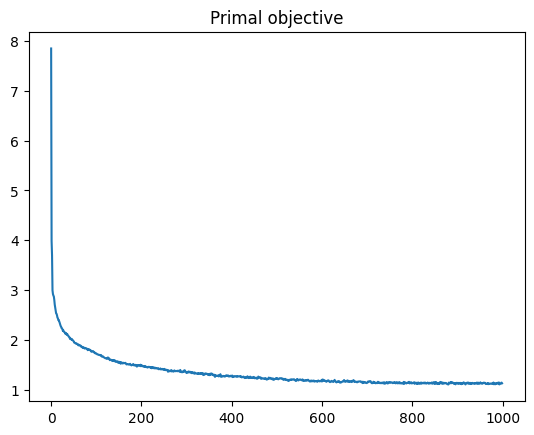

In [18]:
plt.plot(obj_primal)
plt.title("Primal objective")

In [19]:
u = np.full(model_sim.dim, 1); u[2:] = 0
u = u/np.linalg.norm(u)

In [20]:
x_save.shape

torch.Size([1000, 10, 100, 1])

In [21]:
from gwot import bridgesampling as bs

from matplotlib.collections import LineCollection
ts = np.linspace(0, model_sim.t_final, model_sim.T)
with torch.no_grad():
    path = bs.sample_schrodinger_bridge(ts[0], ts[1], model.loss_reg.ot_losses[0].coupling().numpy(), model.x[0, :, :].numpy(), model.x[1, :, :].numpy(), sim.D, 64, 32)

In [22]:
lc = LineCollection(list(map(lambda x: np.vstack([path[1], x[:, 0]]).T, path[0])), alpha = 0.25)

In [23]:
N_paths = 64
N = 16

In [24]:
def sample_brownian_bridge(t, p, N):
    return zip(*[bs.sample_brownian_bridge(t[i], p[i], t[i+1], p[i+1], sim.D, N) for i in range(len(ts)-1)])

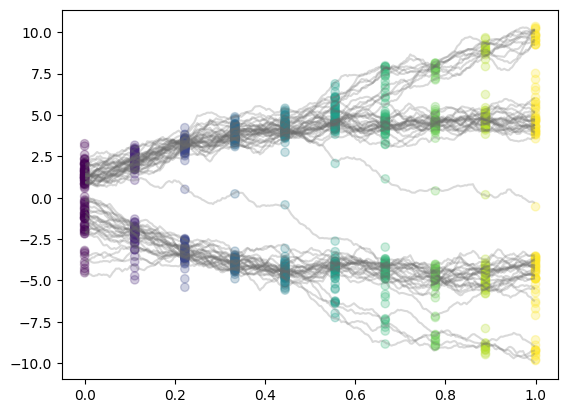

In [25]:
with torch.no_grad():
    plt.scatter(np.kron(np.linspace(0, model_sim.t_final, model_sim.T), np.ones(M)), 
                x_save[-1].reshape(-1, model_sim.dim)[:, 0], 
                c = np.kron(np.arange(model_sim.T), np.ones(M)), alpha = 0.25)
    paths = bs.sample_paths(None, N = N_paths, coord = True, x_all = model.x.cpu().numpy(), 
        get_gamma_fn = lambda i : model.loss_reg.ot_losses[i].coupling().cpu(), num_couplings = model_sim.T-1)
    for i in range(N_paths):
        t = np.hstack(list(sample_brownian_bridge(ts, paths[i], N))[1])
        x = np.vstack(list(sample_brownian_bridge(ts, paths[i], N))[0])
        plt.plot(t, x, color = "dimgray", alpha = 0.25)

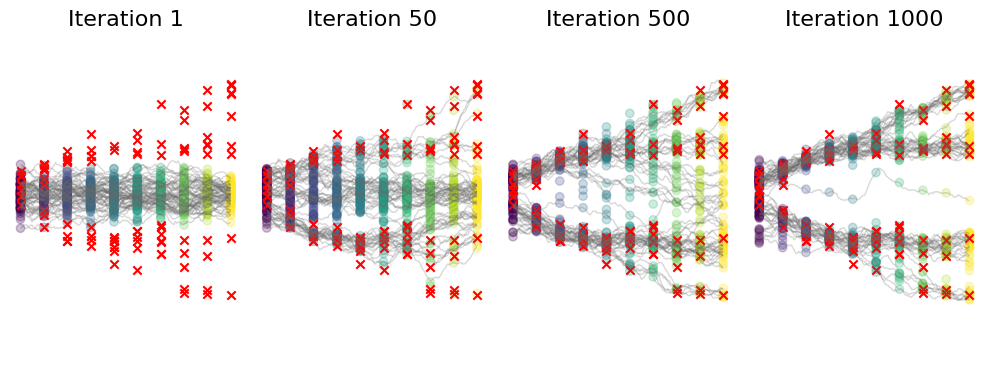

In [26]:
plt.figure(figsize = (4*PLT_CELL, 1.5*PLT_CELL))
for i, t in enumerate([1, 50, 500, 1000]):
    plt.subplot(1, 4, i+1)
    plt.title("Iteration %d" % t, fontsize = 16)
    plt.scatter(np.kron(np.linspace(0, model_sim.t_final, model_sim.T), np.ones(M)), 
                x_save[t-1].reshape(-1, model_sim.dim)[:, 0], 
                c = np.kron(np.arange(model_sim.T), np.ones(M)), alpha = 0.25)
    model_tmp = gen_model(x_save[t-1])
    model_tmp.loss_reg.forward()
    with torch.no_grad():
        paths = bs.sample_paths(None, N = N_paths, coord = True, x_all = model_tmp.x.cpu().numpy(), 
            get_gamma_fn = lambda i : model_tmp.loss_reg.ot_losses[i].coupling().cpu(), num_couplings = model_sim.T-1)
        for i in range(N_paths):
            t = np.hstack(list(sample_brownian_bridge(ts, paths[i], N))[1])
            x = np.vstack(list(sample_brownian_bridge(ts, paths[i], N))[0])
            plt.plot(t, x, color = "dimgrey", alpha = 0.25, linewidth = 1)
    plt.scatter(np.linspace(0, model_sim.t_final, model_sim.T)[sim.t_idx], sim.x[:, k], alpha = 1.0, color = "red", marker = "x")
    plt.ylim(-15.0, 15.0)
    plt.axis("off")
plt.tight_layout()
plt.savefig("fig_poster.pdf")